In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import time

In [99]:
#Get data into dataframe
train_data = pd.read_csv(r'data\train.csv')
test_data = pd.read_csv(r'data\test.csv')

In [100]:
# Split into labels and inputs
labels = train_data['label'].values
inputs = train_data.drop('label', axis=1).values

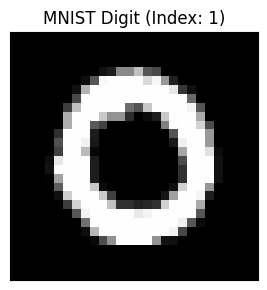

In [101]:
import matplotlib.pyplot as plt

image_index = 1
image = inputs[image_index].reshape(28, 28)

# Create a smaller figure and axis
fig, ax = plt.subplots(figsize=(3, 3))  # Reduced from (6, 6) to (3, 3)

# Display the image
im = ax.imshow(image, cmap='gray')

# Remove axis ticks for a cleaner look
ax.set_xticks([])
ax.set_yticks([])

# Add a title
ax.set_title(f"MNIST Digit (Index: {image_index})")

# Adjust the layout to prevent cutoff
plt.tight_layout()

# Show the plot
plt.show()

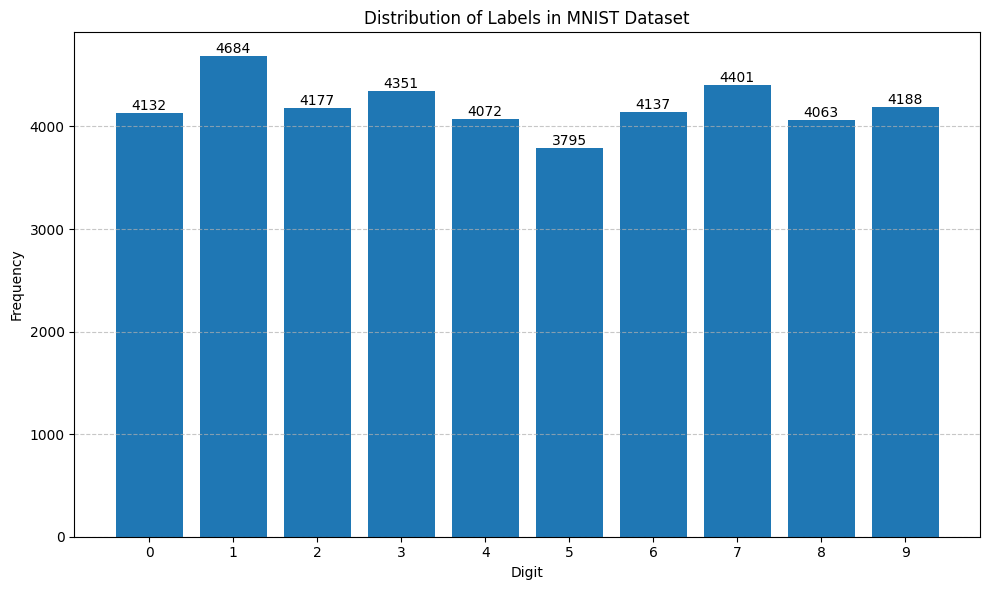

In [102]:
# Count the occurrences of each label
label_counts = Counter(labels)
# Sort the counts by label
sorted_counts = sorted(label_counts.items())
# Separate the labels and counts
x, y = zip(*sorted_counts)
# Create the bar plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x, y)

#Customize the plot
ax.set_xlabel('Digit')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Labels in MNIST Dataset')
ax.set_xticks(range(10))

# Add value labels on top of each bar
for i, v in enumerate(y):
    ax.text(i, v, str(v), ha='center', va='bottom')

# Add a grid for better readability
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

In [103]:
def one_hot_encode(labels):
    #Get unique labels and create a mapping from label to index
    unique_labels, label_indicies = np.unique(labels, return_inverse=True)

    #Use np.eye to create one-hot encoded matrix
    one_hot = np.eye(len(unique_labels))[label_indicies]

    return one_hot

In [104]:
def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        np.random.seed(random_state)
    
    num_samples = X.shape[0]
    num_test = int(num_samples * test_size)
    
    # Create random permutation of indices
    indices = np.random.permutation(num_samples)
    
    # Split indices
    test_indices = indices[:num_test]
    train_indices = indices[num_test:]
    
    # Split data
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    return X_train, X_test, y_train, y_test


In [105]:
#One hot encode
one_hot_encode(labels)

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [106]:
class Activation_ReLu:
    def forward(self, inputs):
        # Store the input values for later use in backpropagation
        self.inputs = inputs
        
        # Apply the ReLU activation function
        # ReLU returns 0 for any negative input, and the input itself for any positive input
        self.output = np.maximum(0, inputs)

        return self.output  # Make sure to return the output
        
        # The np.maximum function compares each element of the inputs array with 0
        # and returns an array with the maximum of the two for each element
        
        # This effectively "activates" neurons: 
        # - Neurons with negative inputs are not activated (output 0)
        # - Neurons with positive inputs are activated (output equals input)

    def backward(self, dvalues):
        # Since we need to modify the original variable,
        # let's make a copy of the values first
        self.dinputs = dvalues.copy()

        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

        return self.dinputs
        



In [107]:
class Softmax_CategoricalCrossEntropy():
    def forward(self, inputs, y_true):
        #get unnormalised probabilites, ensures there is no overflow
        #Softmax part
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        #normalised probabilites
        probabilites = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilites

        #CategoricalCrossEntropy part

        #clip data to prevent division by 0
        #Clip both sides to prevent mean being dragged to any value
        y_pred_clipped = np.clip(probabilites, 1e-7, 1 - 1e-7)

        #Probabilites for target values
        #only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(len(probabilites)), y_true]
        # Mask values - only for one-hot encoded labels, sums across the row
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)

        #Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):
        #number of samples
        samples = len(dvalues)

        #If labels are one-hot encoded
        #Finds the max value along each row and returns a 1D array where each element is the index of the 1 in the corresponding row
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        
        #copy to modify safely
        self.dinputs = dvalues.copy()
        #calculate gradient
        #calulate gradient
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples

        return self.dinputs

    def calculate(self, inputs, y):
        sample_losses = self.forward(inputs, y)
        data_loss = np.mean(sample_losses)
        return data_loss

In [108]:
class DenseLayer():
    def __init__(self, n_inputs, n_neurons, l1=0, l2=0):
        # He initialization for weights
        # The formula is: weight = random_normal() * sqrt(2 / n_inputs)
        # This helps maintain the variance of activations through the network
        self.weights = np.random.randn(n_inputs, n_neurons) * np.sqrt(2.0 / n_inputs)

        #biases shape (1, n_neurons)
        #intialise to zero
        self.biases = np.zeros((1, n_neurons))
        self.dweights = None
        self.dbiases = None
        self.l1 = l1
        self.l2 = l2
    
    def forward(self, inputs):
        #store input values for use in backward pass
        self.inputs = inputs
        #Compute output  y = x*W +b
        self.output = np.dot(inputs, self.weights) + self.biases
        return self.output

    def backward(self, dvalues):
        # dvalues shape: (batch_size, n_neurons)

        # Gradients on parameters
        # self.inputs shape: (batch_size, n_inputs)
        # dvalues shape: (batch_size, n_neurons)
        # self.dweights shape: (n_inputs, n_neurons)

        #Need to transpose self.inputs to match the shape of dvalues
        self.dweights = np.dot(self.inputs.T, dvalues)

        #Gradients on biases
        #Sum vertically (for each neuron)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)

        # L1 regularization on weights
        if self.l1 > 0:
            dL1 = np.ones_like(self.weights)
            dL1[self.weights < 0] = -1
            self.dweights += self.l1 * dL1

        # L2 regularization on weights
        if self.l2 > 0:
            self.dweights += 2 * self.l2 * self.weights

        # Gradient on inputs
        # self.weights shape: (n_inputs, n_neurons)
        # dvalues shape: (batch_size, n_neurons)
        # self.dinputs shape: (batch_size, n_inputs)

        #Need to transpose 
        self.dinputs = np.dot(dvalues, self.weights.T)
        
        return self.dinputs


In [109]:
class Optimizer_Adam():
    def __init__(self, learning_rate=0.001, decay=0, epsilon=1e-7, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta_1 = beta_1
        self.beta_2 = beta_2

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):
        if not hasattr(layer, 'weight_cache'):
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.biases)
            layer.bias_cache = np.zeros_like(layer.biases)

        layer.weight_momentums = self.beta_1 * layer.weight_momentums + (1 - self.beta_1) * layer.dweights
        layer.bias_momentums = self.beta_1 * layer.bias_momentums + (1 - self.beta_1) * layer.dbiases

        # Correct the error here: Change multiplication to division
        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta_1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta_1 ** (self.iterations + 1))

        layer.weight_cache = self.beta_2 * layer.weight_cache + (1 - self.beta_2) * layer.dweights**2
        layer.bias_cache = self.beta_2 * layer.bias_cache + (1 - self.beta_2) * layer.dbiases**2

        weight_cache_corrected = layer.weight_cache / (1 - self.beta_2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta_2 ** (self.iterations + 1))

        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.biases += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

    def post_update_params(self):
        self.iterations += 1

In [110]:
class Dropout:
    def __init__(self, rate):
        self.rate = 1 - rate  # Store the keep rate (1 - dropout rate)
        self.mask = None

    def forward(self, inputs):
        # Create a mask of 1's and 0's with probability of keeping a node = self.rate
        self.mask = np.random.binomial(1, self.rate, size=inputs.shape) / self.rate
        return inputs * self.mask  # Apply mask to inputs

    def backward(self, dvalues):
        # Apply the same mask to the gradient
        return dvalues * self.mask

In [111]:
class NeuralNetwork:
    def __init__(self, l1=0, l2=0, learning_rate=0.001, decay=1e-5):
        self.l1 = l1
        self.l2 = l2
        self.learning_rate = learning_rate
        self.decay = decay
        
        # Define the network architecture
        self.layers = [
            DenseLayer(784, 128, l1=self.l1, l2=self.l2),
            Activation_ReLu(),
            Dropout(0.1),  #dropout rate
            DenseLayer(128, 64, l1=self.l1, l2=self.l2),
            Activation_ReLu(),
            Dropout(0.1),  # dropout rate
            DenseLayer(64, 32, l1=self.l1, l2=self.l2),
            Activation_ReLu(),
            DenseLayer(32, 10, l1=self.l1, l2=self.l2),
        ]
        
        # Define loss function
        self.loss_activation = Softmax_CategoricalCrossEntropy()
        
        # Initialize optimizer with provided learning rate and decay
        self.optimizer = Optimizer_Adam(learning_rate=self.learning_rate, decay=self.decay)

    def evaluate(self, X, y):
        # Forward pass
        output = self.forward(X, training=False)
        
        # Calculate loss
        loss = self.loss_activation.calculate(output, y)
        
        # Calculate accuracy
        predictions = np.argmax(output, axis=1)
        accuracy = np.mean(predictions == np.argmax(y, axis=1))
        
        return loss, accuracy

    def forward(self, X, training=True):
        # Forward pass through all layers
        for layer in self.layers:
            if isinstance(layer, Dropout):
                # Apply dropout only during training
                X = layer.forward(X) if training else X
            else:
                X = layer.forward(X)
        return X
    
    def backward(self, output, y):
        # Backward pass starting from the loss
        dinputs = self.loss_activation.backward(output, y)
        for layer in reversed(self.layers):
            dinputs = layer.backward(dinputs)
        return dinputs
    
    def train(self, X_train, y_train, X_test, y_test, epochs, batch_size):
        total_start_time = time.time()

        for epoch in range(epochs):
            epoch_start_time = time.time()
            
            # Shuffle the training data
            permutation = np.random.permutation(len(X_train))
            X_shuffled = X_train[permutation]
            y_shuffled = y_train[permutation]

            # Train in batches
            for i in range(0, len(X_train), batch_size):
                X_batch = X_shuffled[i:i+batch_size]
                y_batch = y_shuffled[i:i+batch_size]

                # Forward pass
                output = self.forward(X_batch, training=True)
                
                # Backward pass
                self.backward(output, y_batch)

                # Update parameters
                self.optimizer.pre_update_params()
                for layer in self.layers:
                    if isinstance(layer, DenseLayer):
                        self.optimizer.update_params(layer)
                self.optimizer.post_update_params()

            # Evaluate the model after each epoch
            train_loss, train_accuracy = self.evaluate(X_train, y_train)
            test_loss, test_accuracy = self.evaluate(X_test, y_test)
            
            epoch_end_time = time.time()
            epoch_duration = epoch_end_time - epoch_start_time
            
            print(f"Epoch {epoch+1}/{epochs}, "
                f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
                f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, "
                f"Time: {epoch_duration:.2f} seconds")
        
        total_end_time = time.time()
        total_duration = total_end_time - total_start_time
        print(f"\nTotal training time: {total_duration:.2f} seconds")

In [112]:
def predict(model, X):
    # Forward pass
    output = model.forward(X, training=False)
    
    # Get predictions
    predictions = np.argmax(output, axis=1)
    
    return predictions

In [113]:
def create_submission(predictions, filename='submission.csv'):
    # Create a DataFrame with the predictions
    submission = pd.DataFrame({
        'ImageId': range(1, len(predictions) + 1),
        'Label': predictions
    })
    
    # Save to CSV
    submission.to_csv(filename, index=False)
    print(f"Submission saved to {filename}")

In [114]:
# Split the data
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(inputs, labels, test_size=0.2, random_state=42)

In [115]:
# Normalize inputs
X_train = X_train_raw / 255.0
X_test = X_test_raw / 255.0

# One-hot encode labels
y_train = one_hot_encode(y_train_raw)
y_test = one_hot_encode(y_test_raw)

In [116]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (33600, 784)
y_train shape: (33600, 10)


In [117]:
#parameters 
l1 = 1e-8
l2 = 0.000001
learning_rate = 3e-4
decay_rate = 3e-6
epochs = 30
batch_size = 32

In [118]:
nn = NeuralNetwork(l1, l2, learning_rate, decay_rate )

print("Network structure:")
for i, layer in enumerate(nn.layers):
    print(f"Layer {i}: {type(layer).__name__}")

print("\nStarting training...")
nn = NeuralNetwork(l1, l2, learning_rate, decay_rate)
nn.train(X_train, y_train, X_test, y_test, epochs, batch_size)

Network structure:
Layer 0: DenseLayer
Layer 1: Activation_ReLu
Layer 2: Dropout
Layer 3: DenseLayer
Layer 4: Activation_ReLu
Layer 5: Dropout
Layer 6: DenseLayer
Layer 7: Activation_ReLu
Layer 8: DenseLayer

Starting training...
Epoch 1/30, Train Loss: 1.6878, Train Accuracy: 0.9179, Test Loss: 1.6925, Test Accuracy: 0.9112, Time: 2.70 seconds
Epoch 2/30, Train Loss: 1.6069, Train Accuracy: 0.9510, Test Loss: 1.6140, Test Accuracy: 0.9420, Time: 2.60 seconds
Epoch 3/30, Train Loss: 1.5828, Train Accuracy: 0.9640, Test Loss: 1.5899, Test Accuracy: 0.9551, Time: 2.58 seconds
Epoch 4/30, Train Loss: 1.5541, Train Accuracy: 0.9709, Test Loss: 1.5632, Test Accuracy: 0.9613, Time: 2.67 seconds
Epoch 5/30, Train Loss: 1.5413, Train Accuracy: 0.9770, Test Loss: 1.5539, Test Accuracy: 0.9644, Time: 2.68 seconds
Epoch 6/30, Train Loss: 1.5315, Train Accuracy: 0.9810, Test Loss: 1.5454, Test Accuracy: 0.9675, Time: 2.55 seconds
Epoch 7/30, Train Loss: 1.5215, Train Accuracy: 0.9850, Test Loss: 1

In [ ]:
#Evaluating test.csv
# Load test data
test_data = pd.read_csv(r'data\test.csv')

# Preprocess test data
X_test = test_data.values.astype('float32')
X_test /= 255.0  # Normalize the data

In [ ]:
# Make predictions on the test data
test_predictions = predict(nn, X_test)

print("Test predictions shape:", test_predictions.shape)

Test predictions shape: (28000,)


In [ ]:
create_submission(test_predictions)

Submission saved to submission.csv
